In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import albumentations as A
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models


from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import seaborn as sns

from typing import Optional, Any, Tuple
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score
)


In [8]:
# !pip install -r ./requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
DEV_MODE = 'COLAB'
# DATA_FOLDER = "/tudelft.net/staff-umbrella/NightId/pbateni/pbt-plaque-analysis/data/labeled_images" if DEV_MODE=='HPC' else ('drive/MyDrive/pbt-plaque-analysis/data/labeled_images' if DEV_MODE=='COLAB' else "data/labeled_images")
DATA_FOLDER = "data/labeled_images"
CLASS_TO_LABEL = {"CAA": 0, "Coarse":1, "Compact":2, "Cored": 3, "Diffuse": 4, "NonAB":5, "OtherAB":6, "Subpial": 7, "UndefAB":8}
LABEL_TO_CLASS = {v:k for k,v in CLASS_TO_LABEL.items()}
SCALED_SIZE = (224, 224)  # Adjust as needed
RANDOM_SEED = 44
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

STRATIFY_SAMPLES = True
TRANSFORM_TRAIN = False

NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE= 1e-5
NUM_WORKERS = 2

In [3]:
total_images = 0
total_size = 0
for class_folder in os.listdir(DATA_FOLDER):
    folder_path = os.path.join(DATA_FOLDER, class_folder)
    for f in os.listdir(folder_path):
        if f.endswith('.png'):
            total_images += 1
            total_size += os.path.getsize(os.path.join(folder_path, f))

print(f"Total images: {total_images}")
print(f"Total size: {total_size / (1024 ** 2):.2f} MB")

Total images: 589
Total size: 96.24 MB


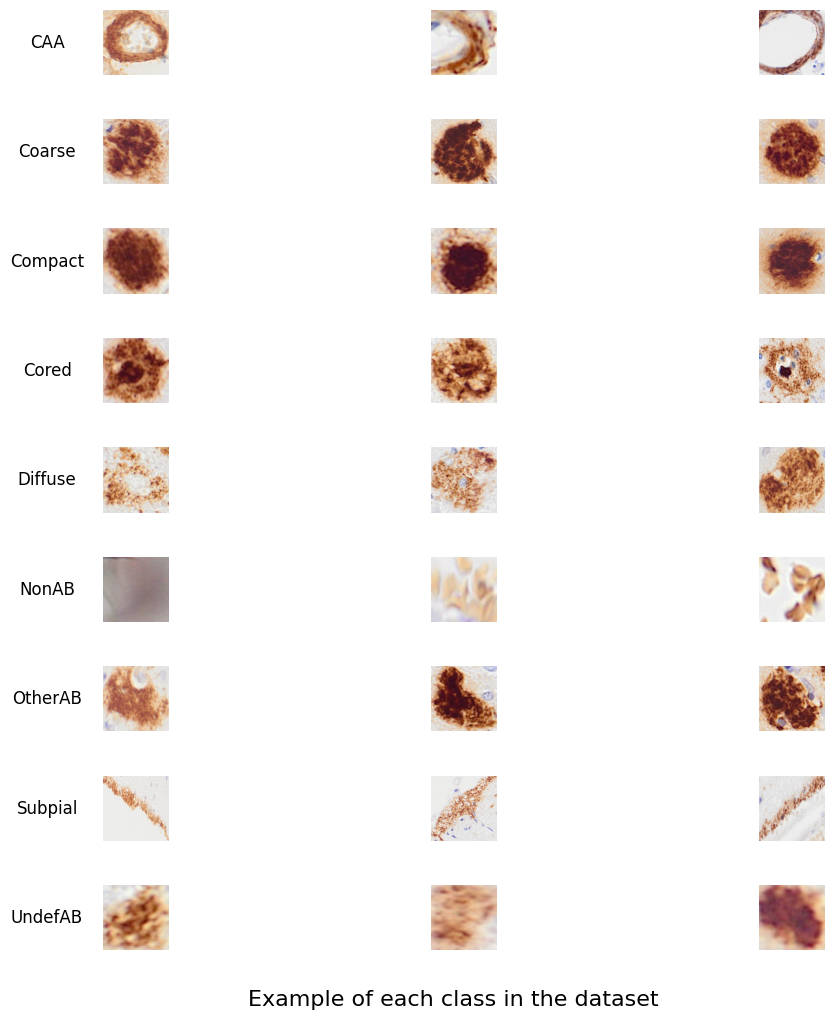

In [4]:
# show an example of each class in data folder
count_examples = 3
fig, ax = plt.subplots(len(os.listdir(DATA_FOLDER)), count_examples, figsize=(10, 10))
plt.tight_layout()
fig.suptitle('Example of each class in the dataset', fontsize=16, y = 0)
np.random.seed(RANDOM_SEED)
for i, class_folder in enumerate(sorted(os.listdir(DATA_FOLDER))):
    class_path = os.path.join(DATA_FOLDER, class_folder)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        examples = np.random.choice(files, min(count_examples, len(files)), replace=False)
        for j, example in enumerate(examples):
            example_path = os.path.join(class_path, example)
            img = Image.open(example_path).convert("RGB")  # Ensure consistent format
            img = img.resize(SCALED_SIZE, Image.BILINEAR)
            img = np.array(img, dtype=np.int32)  # Explicit dtype control
            ax[i, j].imshow(img)
            # Hide ticks and spines for all axes
            ax[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            for spine in ax[i, j].spines.values():
                spine.set_visible(False)
        # Set the row label on the left of the row
        ax[i, 0].set_ylabel(class_folder, rotation=0, size='large', labelpad=40, va='center')
        # Show the y-label for the first column only
        ax[i, 0].yaxis.set_visible(True)
plt.show()

In [5]:
for image_class in os.listdir(DATA_FOLDER):
    print(f"{image_class}: {len(os.listdir(os.path.join(DATA_FOLDER, image_class)))}")

CAA: 74
Coarse: 79
Compact: 63
Cored: 107
Diffuse: 81
NonAB: 38
OtherAB: 31
Subpial: 73
UndefAB: 43


In [8]:
image_paths = []
image_labels = []
for class_name, label in CLASS_TO_LABEL.items():
    files = os.listdir(os.path.join(DATA_FOLDER, class_name))
    image_paths.extend([os.path.join(DATA_FOLDER, class_name, f) for f in files])
    image_labels.extend(len(files)*[label])
train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(image_paths, image_labels, test_size=TEST_SIZE, stratify=image_labels if STRATIFY_SAMPLES else None)
train_image_paths, validation_image_paths, train_image_labels, validation_image_labels = train_test_split(train_image_paths, train_image_labels, test_size=VALIDATION_SIZE, stratify=train_image_labels if STRATIFY_SAMPLES else None)

In [38]:
# plt.hist([plt.imread(path).shape[0] for path in train_image_paths], range=(0,1000))
# plt.show()

In [9]:
class PlaqueDataset(Dataset):
    def __init__(self, image_paths: List[str], image_labels: List[int], transform: A.Compose = None, preload_images: bool = True):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform
        self.images = []
        if preload_images:
          with ThreadPoolExecutor() as executor:
              for result in tqdm(executor.map(self.load_image, self.image_paths), total=len(self.image_paths), position=0, leave=True):
                  self.images.append(result)
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = self.images[idx] if self.images else self.load_image(self.image_paths[idx])

        if self.transform:
          # Apply Albumentations transform expects HWC, so transpose back temporarily
          image = np.transpose(image, (1, 2, 0))  # [C, H, W] -> [H, W, C]
          image = self.transform(image=image)['image']

          # Convert to tensor, ensure shape [C, H, W]
          image = np.transpose(image, (2, 0, 1))  # [H, W, C] -> [C, H, W]

        label = self.image_labels[idx]
        return torch.tensor(image, dtype=torch.float32), label

    def load_image(self, image_path: str) -> np.ndarray:
        img = Image.open(image_path).convert("RGB")  # Always [H, W, C]
        img = img.resize(SCALED_SIZE, Image.BILINEAR)
        image = np.array(img, dtype=np.float32)      # Still [H, W, C]
        image = np.transpose(image, (2, 0, 1))       # Convert to [C, H, W]
        return image

In [10]:
max_dim = (0,0)
dims = []
for folder in os.listdir(DATA_FOLDER):
    for image in os.listdir(os.path.join(DATA_FOLDER, folder)):
        img = Image.open(os.path.join(DATA_FOLDER, folder, image))
        width, height = img.size
        dims.append((width, height))
sorted_dims = sorted(dims, key=lambda x: -x[0] * x[1])
print(f"Max dimension: {sorted_dims[:10]}")
print(f"Average dimensions: {np.mean(dims, axis=0)}")


Max dimension: [(1643, 954), (801, 998), (1535, 362), (618, 575), (691, 347), (508, 459), (408, 550), (515, 425), (430, 495), (417, 507)]
Average dimensions: [134.24617997 123.30050934]


In [11]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3)
])


train_dataset = PlaqueDataset(train_image_paths, train_image_labels, transform=train_transforms if TRANSFORM_TRAIN else None)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,     # Shuffles the data each epoch (recommended for training)
    pin_memory=True   # Recommended if using CUDA
)

validation_dataset = PlaqueDataset(validation_image_paths, validation_image_labels)
validation_loader = DataLoader(
    validation_dataset,
    batch_size = BATCH_SIZE,
    shuffle= False,
    pin_memory = True
)


test_dataset = PlaqueDataset(test_image_paths, test_image_labels)
test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle= False,
    pin_memory = True
)

  0%|          | 0/376 [00:00<?, ?it/s]

100%|██████████| 118/118 [00:00<00:00, 622.45it/s]


In [12]:
print(f"CUDA is available: {torch.cuda.is_available()}")

CUDA is available: False


In [13]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes:int):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [14]:
# Assuming your evaluate function returns predictions, avg_loss, acc
def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: str = 'cpu'
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    model.eval()
    data_loss = 0.0
    count = 0
    total = 0
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.float().to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            data_loss += loss.item() * images.size(0)

            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            probabilities.extend(probs.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            count += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = data_loss / total
    acc = count/total
    return acc, avg_loss, np.array(predictions), np.array(probabilities)

# Function to generate the metrics table
def generate_metrics_table(predictions: np.ndarray, true_labels: np.ndarray, probabilities: np.ndarray) -> pd.DataFrame:
    table_data = []

    # Overall metrics
    acc = accuracy_score(true_labels, predictions) * 100
    precision = precision_score(true_labels, predictions, average='macro') * 100
    recall = recall_score(true_labels, predictions, average='macro') * 100
    f1 = f1_score(true_labels, predictions, average='macro') * 100
    roc_auc = roc_auc_score(true_labels, probabilities, multi_class='ovr') * 100

    table_data.append(["Overall", f"{acc:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}", f"{roc_auc:.2f}"])

    # Per-class metrics
    for class_name in list(CLASS_TO_LABEL.keys()):
        label = CLASS_TO_LABEL[class_name]
        class_mask = (true_labels == label)
        if np.sum(class_mask) == 0:
            table_data.append([class_name, "-", "-", "-", "-", "-"])
            continue

        correct_mask = (np.array(predictions) == label)
        class_accuracy = 100. * np.sum(class_mask & correct_mask) / np.sum(class_mask)
        class_precision = precision_score(true_labels, predictions, labels=[label], average='macro') * 100
        class_recall = recall_score(true_labels, predictions, labels=[label], average='macro') * 100
        class_f1 = f1_score(true_labels, predictions, labels=[label], average='macro') * 100

        # try:
        class_roc_auc = roc_auc_score((true_labels == label).astype(int), probabilities[:, label]) * 100
        # except:
            # class_roc_auc = np.nan

        table_data.append([
            class_name,
            f"{class_accuracy:.2f}",
            f"{class_precision:.2f}",
            f"{class_recall:.2f}",
            f"{class_f1:.2f}",
            f"{class_roc_auc:.2f}" if not np.isnan(class_roc_auc) else "-"
        ])

    df = pd.DataFrame(table_data, columns=["Class", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
    return df




def train(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    val_loader: Optional[DataLoader] = None,
    device: str = 'cpu',
    num_epochs: int = 10,
    patience: int = 3,
    early_stopping: bool = False
) -> Tuple[List[float], List[float]]:
    model.to(device)
    epoch_losses = []
    epoch_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in loop:
            images = images.float().to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)

        # Validation Step
        val_acc, val_loss, _, _ = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

        if early_stopping:
          # Early Stopping Check
          if val_loss < best_val_loss:
              best_val_loss = val_loss
              epochs_no_improve = 0
              best_model_state = model.state_dict()
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= patience:
                  print(f"Early stopping triggered after {epoch+1} epochs!")
                  model.load_state_dict(best_model_state)
                  break

    return epoch_losses, epoch_accuracies, val_losses, val_accuracies

def draw_confusion_matrix(y_true: List[int], y_predicted: List[int]):
  cf = confusion_matrix(list(map(lambda x:LABEL_TO_CLASS[x],  y_true)),list(map(lambda x: LABEL_TO_CLASS[x], y_predicted)), labels = list(CLASS_TO_LABEL.keys()))
  plt.figure(figsize=(20,20))
  sns.heatmap(cf, annot=True, fmt='d')
  plt.xticks(ticks = np.array(list(LABEL_TO_CLASS.keys())) + 0.5 ,labels = list(CLASS_TO_LABEL.keys()))
  plt.yticks(ticks = np.array(list(LABEL_TO_CLASS.keys())) + 0.5, labels = list(CLASS_TO_LABEL.keys()))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [15]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get number of classes from the dataset
num_classes = len(set(train_image_labels))

In [44]:
# Instantiate model, loss, optimizer
simple_model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=LEARNING_RATE)

train(simple_model, train_loader, criterion, optimizer, val_loader = validation_loader, device= device, num_epochs = NUM_EPOCHS, early_stopping=True)
test_acc, test_loss, test_predictions, test_predictions_probabilities = evaluate(simple_model, test_loader, criterion, device)
print(f"Test data average loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
draw_confusion_matrix(test_image_labels, test_predictions)
generate_metrics_table(np.array(test_predictions), np.array(test_image_labels), test_predictions_probabilities)


Epoch [1/50]:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\DELL\Desktop\Honours\pbt-plaque-analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [1/50]: 100%|██████████| 12/12 [00:29<00:00,  2.48s/it, acc=14.9, loss=6.33]


Epoch 1/50 - Train Loss: 9.6711 - Train Acc: 14.89% - Val Loss: 4.2958 - Val Acc: 0.22%


Epoch [2/50]: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it, acc=26.1, loss=2.66]


Epoch 2/50 - Train Loss: 3.3038 - Train Acc: 26.06% - Val Loss: 2.0035 - Val Acc: 0.35%


Epoch [3/50]: 100%|██████████| 12/12 [00:31<00:00,  2.66s/it, acc=30.6, loss=2.29]


Epoch 3/50 - Train Loss: 1.9042 - Train Acc: 30.59% - Val Loss: 1.7570 - Val Acc: 0.29%


Epoch [4/50]: 100%|██████████| 12/12 [00:28<00:00,  2.34s/it, acc=31.9, loss=1.9] 


Epoch 4/50 - Train Loss: 1.8162 - Train Acc: 31.91% - Val Loss: 1.7369 - Val Acc: 0.36%


Epoch [5/50]: 100%|██████████| 12/12 [00:30<00:00,  2.56s/it, acc=38.3, loss=1.99]


Epoch 5/50 - Train Loss: 1.6713 - Train Acc: 38.30% - Val Loss: 1.5978 - Val Acc: 0.41%


Epoch [6/50]: 100%|██████████| 12/12 [00:24<00:00,  2.05s/it, acc=40.2, loss=1.9] 


Epoch 6/50 - Train Loss: 1.6268 - Train Acc: 40.16% - Val Loss: 1.4859 - Val Acc: 0.56%


Epoch [7/50]: 100%|██████████| 12/12 [00:24<00:00,  2.04s/it, acc=42.3, loss=1.47]


Epoch 7/50 - Train Loss: 1.5120 - Train Acc: 42.29% - Val Loss: 1.4918 - Val Acc: 0.55%


Epoch [8/50]: 100%|██████████| 12/12 [00:25<00:00,  2.12s/it, acc=44.1, loss=1.52]


Epoch 8/50 - Train Loss: 1.5184 - Train Acc: 44.15% - Val Loss: 1.4377 - Val Acc: 0.52%


Epoch [9/50]: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it, acc=48.1, loss=1.72]


Epoch 9/50 - Train Loss: 1.4242 - Train Acc: 48.14% - Val Loss: 1.3881 - Val Acc: 0.56%


Epoch [10/50]:  83%|████████▎ | 10/12 [00:26<00:05,  2.66s/it, acc=51.2, loss=1.53]


KeyboardInterrupt: 

In [16]:
# Instantiate model, loss, optimizer
simple_model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=LEARNING_RATE)

train(simple_model, train_loader, criterion, optimizer, val_loader = validation_loader, device= device, num_epochs = NUM_EPOCHS, early_stopping=True)
test_acc, test_loss, test_predictions, test_predictions_probabilities = evaluate(simple_model, test_loader, criterion, device)
print(f"Test data average loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
draw_confusion_matrix(test_image_labels, test_predictions)
generate_metrics_table(np.array(test_predictions), np.array(test_image_labels), test_predictions_probabilities)


Epoch [1/50]:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\DELL\Desktop\Honours\pbt-plaque-analysis\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch [1/50]: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it, acc=13.3, loss=3.46]


Epoch 1/50 - Train Loss: 5.1458 - Train Acc: 13.30% - Val Loss: 3.4277 - Val Acc: 0.14%


Epoch [2/50]: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it, acc=11.7, loss=2.73]


Epoch 2/50 - Train Loss: 2.9012 - Train Acc: 11.70% - Val Loss: 2.2985 - Val Acc: 0.14%


Epoch [3/50]:  17%|█▋        | 2/12 [00:06<00:31,  3.12s/it, acc=26.6, loss=2.07]


KeyboardInterrupt: 

Epoch [1/50]: 100%|██████████| 12/12 [00:01<00:00,  9.20it/s, acc=19.9, loss=1.87]


Epoch 1/50 - Train Loss: 2.0984 - Train Acc: 19.95% - Val Loss: 2.0884 - Val Acc: 0.18%


Epoch [2/50]: 100%|██████████| 12/12 [00:01<00:00,  9.75it/s, acc=42.6, loss=1.84]


Epoch 2/50 - Train Loss: 1.7767 - Train Acc: 42.55% - Val Loss: 1.7952 - Val Acc: 0.35%


Epoch [3/50]: 100%|██████████| 12/12 [00:01<00:00,  9.35it/s, acc=61.2, loss=1.54]


Epoch 3/50 - Train Loss: 1.4855 - Train Acc: 61.17% - Val Loss: 1.5962 - Val Acc: 0.58%


Epoch [4/50]: 100%|██████████| 12/12 [00:01<00:00,  9.22it/s, acc=77.7, loss=1.19]


Epoch 4/50 - Train Loss: 1.2697 - Train Acc: 77.66% - Val Loss: 1.4346 - Val Acc: 0.65%


Epoch [5/50]: 100%|██████████| 12/12 [00:01<00:00,  9.55it/s, acc=80.9, loss=1.08]


Epoch 5/50 - Train Loss: 1.0901 - Train Acc: 80.85% - Val Loss: 1.3040 - Val Acc: 0.71%


Epoch [6/50]: 100%|██████████| 12/12 [00:01<00:00,  7.77it/s, acc=86.4, loss=0.864]


Epoch 6/50 - Train Loss: 0.9495 - Train Acc: 86.44% - Val Loss: 1.1996 - Val Acc: 0.72%


Epoch [7/50]: 100%|██████████| 12/12 [00:01<00:00,  7.72it/s, acc=88.3, loss=0.646]


Epoch 7/50 - Train Loss: 0.7977 - Train Acc: 88.30% - Val Loss: 1.1062 - Val Acc: 0.76%


Epoch [8/50]: 100%|██████████| 12/12 [00:01<00:00,  6.85it/s, acc=91.2, loss=0.618]


Epoch 8/50 - Train Loss: 0.7236 - Train Acc: 91.22% - Val Loss: 1.0314 - Val Acc: 0.77%


Epoch [9/50]: 100%|██████████| 12/12 [00:01<00:00,  9.35it/s, acc=92.8, loss=0.609]


Epoch 9/50 - Train Loss: 0.6133 - Train Acc: 92.82% - Val Loss: 0.9710 - Val Acc: 0.78%


Epoch [10/50]: 100%|██████████| 12/12 [00:01<00:00,  9.71it/s, acc=93.9, loss=0.662]


Epoch 10/50 - Train Loss: 0.5459 - Train Acc: 93.88% - Val Loss: 0.9248 - Val Acc: 0.79%


Epoch [11/50]: 100%|██████████| 12/12 [00:01<00:00,  9.80it/s, acc=94.9, loss=0.529]


Epoch 11/50 - Train Loss: 0.4888 - Train Acc: 94.95% - Val Loss: 0.8750 - Val Acc: 0.80%


Epoch [12/50]: 100%|██████████| 12/12 [00:01<00:00,  9.79it/s, acc=96.3, loss=0.508]


Epoch 12/50 - Train Loss: 0.4315 - Train Acc: 96.28% - Val Loss: 0.8432 - Val Acc: 0.79%


Epoch [13/50]: 100%|██████████| 12/12 [00:01<00:00,  9.79it/s, acc=97.6, loss=0.485]


Epoch 13/50 - Train Loss: 0.3906 - Train Acc: 97.61% - Val Loss: 0.8014 - Val Acc: 0.82%


Epoch [14/50]: 100%|██████████| 12/12 [00:01<00:00,  9.68it/s, acc=98.4, loss=0.328]


Epoch 14/50 - Train Loss: 0.3419 - Train Acc: 98.40% - Val Loss: 0.7703 - Val Acc: 0.83%


Epoch [15/50]: 100%|██████████| 12/12 [00:01<00:00,  9.51it/s, acc=98.9, loss=0.321]


Epoch 15/50 - Train Loss: 0.3159 - Train Acc: 98.94% - Val Loss: 0.7481 - Val Acc: 0.82%


Epoch [16/50]: 100%|██████████| 12/12 [00:01<00:00,  9.17it/s, acc=98.7, loss=0.246]


Epoch 16/50 - Train Loss: 0.2643 - Train Acc: 98.67% - Val Loss: 0.7255 - Val Acc: 0.81%


Epoch [17/50]: 100%|██████████| 12/12 [00:01<00:00,  8.04it/s, acc=98.7, loss=0.242]


Epoch 17/50 - Train Loss: 0.2569 - Train Acc: 98.67% - Val Loss: 0.7138 - Val Acc: 0.80%


Epoch [18/50]: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s, acc=99.7, loss=0.19]


Epoch 18/50 - Train Loss: 0.2230 - Train Acc: 99.73% - Val Loss: 0.6926 - Val Acc: 0.81%


Epoch [19/50]: 100%|██████████| 12/12 [00:01<00:00,  7.94it/s, acc=99.7, loss=0.32]


Epoch 19/50 - Train Loss: 0.2063 - Train Acc: 99.73% - Val Loss: 0.6784 - Val Acc: 0.82%


Epoch [20/50]: 100%|██████████| 12/12 [00:01<00:00,  8.66it/s, acc=99.7, loss=0.31]


Epoch 20/50 - Train Loss: 0.1979 - Train Acc: 99.73% - Val Loss: 0.6579 - Val Acc: 0.83%


Epoch [21/50]: 100%|██████████| 12/12 [00:01<00:00,  8.52it/s, acc=99.7, loss=0.16]


Epoch 21/50 - Train Loss: 0.1549 - Train Acc: 99.73% - Val Loss: 0.6491 - Val Acc: 0.84%


Epoch [22/50]: 100%|██████████| 12/12 [00:01<00:00,  9.36it/s, acc=99.5, loss=0.168]


Epoch 22/50 - Train Loss: 0.1568 - Train Acc: 99.47% - Val Loss: 0.6366 - Val Acc: 0.83%


Epoch [23/50]: 100%|██████████| 12/12 [00:01<00:00,  9.74it/s, acc=100, loss=0.0995]


Epoch 23/50 - Train Loss: 0.1282 - Train Acc: 100.00% - Val Loss: 0.6266 - Val Acc: 0.82%


Epoch [24/50]: 100%|██████████| 12/12 [00:01<00:00,  9.71it/s, acc=100, loss=0.121]


Epoch 24/50 - Train Loss: 0.1163 - Train Acc: 100.00% - Val Loss: 0.6178 - Val Acc: 0.82%


Epoch [25/50]: 100%|██████████| 12/12 [00:01<00:00,  9.74it/s, acc=100, loss=0.179]


Epoch 25/50 - Train Loss: 0.1329 - Train Acc: 100.00% - Val Loss: 0.6118 - Val Acc: 0.81%


Epoch [26/50]: 100%|██████████| 12/12 [00:01<00:00,  9.54it/s, acc=100, loss=0.0686]


Epoch 26/50 - Train Loss: 0.0993 - Train Acc: 100.00% - Val Loss: 0.6019 - Val Acc: 0.82%


Epoch [27/50]: 100%|██████████| 12/12 [00:01<00:00,  9.45it/s, acc=100, loss=0.118]


Epoch 27/50 - Train Loss: 0.0960 - Train Acc: 100.00% - Val Loss: 0.5904 - Val Acc: 0.83%


Epoch [28/50]: 100%|██████████| 12/12 [00:01<00:00,  9.39it/s, acc=100, loss=0.106]


Epoch 28/50 - Train Loss: 0.0981 - Train Acc: 100.00% - Val Loss: 0.5766 - Val Acc: 0.84%


Epoch [29/50]: 100%|██████████| 12/12 [00:01<00:00,  9.72it/s, acc=100, loss=0.159]


Epoch 29/50 - Train Loss: 0.0834 - Train Acc: 100.00% - Val Loss: 0.5721 - Val Acc: 0.84%


Epoch [30/50]: 100%|██████████| 12/12 [00:01<00:00,  9.71it/s, acc=99.7, loss=0.0835]


Epoch 30/50 - Train Loss: 0.0840 - Train Acc: 99.73% - Val Loss: 0.5685 - Val Acc: 0.84%


Epoch [31/50]: 100%|██████████| 12/12 [00:01<00:00,  9.67it/s, acc=100, loss=0.152]


Epoch 31/50 - Train Loss: 0.0871 - Train Acc: 100.00% - Val Loss: 0.5601 - Val Acc: 0.84%


Epoch [32/50]: 100%|██████████| 12/12 [00:01<00:00,  9.77it/s, acc=100, loss=0.111]


Epoch 32/50 - Train Loss: 0.0784 - Train Acc: 100.00% - Val Loss: 0.5597 - Val Acc: 0.83%


Epoch [33/50]: 100%|██████████| 12/12 [00:01<00:00,  9.67it/s, acc=100, loss=0.057]


Epoch 33/50 - Train Loss: 0.0653 - Train Acc: 100.00% - Val Loss: 0.5521 - Val Acc: 0.84%


Epoch [34/50]: 100%|██████████| 12/12 [00:01<00:00,  9.73it/s, acc=100, loss=0.0816]


Epoch 34/50 - Train Loss: 0.0708 - Train Acc: 100.00% - Val Loss: 0.5557 - Val Acc: 0.84%


Epoch [35/50]: 100%|██████████| 12/12 [00:01<00:00,  9.66it/s, acc=100, loss=0.0453]


Epoch 35/50 - Train Loss: 0.0580 - Train Acc: 100.00% - Val Loss: 0.5501 - Val Acc: 0.84%


Epoch [36/50]: 100%|██████████| 12/12 [00:01<00:00,  9.42it/s, acc=100, loss=0.0422]


Epoch 36/50 - Train Loss: 0.0569 - Train Acc: 100.00% - Val Loss: 0.5452 - Val Acc: 0.85%


Epoch [37/50]: 100%|██████████| 12/12 [00:01<00:00,  9.33it/s, acc=100, loss=0.0754]


Epoch 37/50 - Train Loss: 0.0558 - Train Acc: 100.00% - Val Loss: 0.5417 - Val Acc: 0.83%


Epoch [38/50]: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s, acc=100, loss=0.0585]


Epoch 38/50 - Train Loss: 0.0509 - Train Acc: 100.00% - Val Loss: 0.5361 - Val Acc: 0.85%


Epoch [39/50]: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, acc=100, loss=0.0319]


Epoch 39/50 - Train Loss: 0.0454 - Train Acc: 100.00% - Val Loss: 0.5357 - Val Acc: 0.83%


Epoch [40/50]: 100%|██████████| 12/12 [00:01<00:00,  9.64it/s, acc=100, loss=0.0493]


Epoch 40/50 - Train Loss: 0.0497 - Train Acc: 100.00% - Val Loss: 0.5281 - Val Acc: 0.83%


Epoch [41/50]: 100%|██████████| 12/12 [00:01<00:00,  9.63it/s, acc=100, loss=0.0554]


Epoch 41/50 - Train Loss: 0.0376 - Train Acc: 100.00% - Val Loss: 0.5238 - Val Acc: 0.84%


Epoch [42/50]: 100%|██████████| 12/12 [00:01<00:00,  9.73it/s, acc=100, loss=0.0896]


Epoch 42/50 - Train Loss: 0.0422 - Train Acc: 100.00% - Val Loss: 0.5264 - Val Acc: 0.84%


Epoch [43/50]: 100%|██████████| 12/12 [00:01<00:00,  9.64it/s, acc=100, loss=0.089]


Epoch 43/50 - Train Loss: 0.0422 - Train Acc: 100.00% - Val Loss: 0.5284 - Val Acc: 0.84%


Epoch [44/50]: 100%|██████████| 12/12 [00:01<00:00,  9.69it/s, acc=100, loss=0.0276]


Epoch 44/50 - Train Loss: 0.0397 - Train Acc: 100.00% - Val Loss: 0.5163 - Val Acc: 0.84%


Epoch [45/50]: 100%|██████████| 12/12 [00:01<00:00,  9.55it/s, acc=100, loss=0.0571]


Epoch 45/50 - Train Loss: 0.0333 - Train Acc: 100.00% - Val Loss: 0.5093 - Val Acc: 0.85%


Epoch [46/50]: 100%|██████████| 12/12 [00:01<00:00,  9.33it/s, acc=100, loss=0.0272]


Epoch 46/50 - Train Loss: 0.0315 - Train Acc: 100.00% - Val Loss: 0.5101 - Val Acc: 0.85%


Epoch [47/50]: 100%|██████████| 12/12 [00:01<00:00,  9.28it/s, acc=100, loss=0.0372]


Epoch 47/50 - Train Loss: 0.0350 - Train Acc: 100.00% - Val Loss: 0.5053 - Val Acc: 0.86%


Epoch [48/50]: 100%|██████████| 12/12 [00:01<00:00,  9.57it/s, acc=100, loss=0.0461]


Epoch 48/50 - Train Loss: 0.0375 - Train Acc: 100.00% - Val Loss: 0.5036 - Val Acc: 0.85%


Epoch [49/50]: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, acc=100, loss=0.0761]


Epoch 49/50 - Train Loss: 0.0338 - Train Acc: 100.00% - Val Loss: 0.5001 - Val Acc: 0.84%


Epoch [50/50]: 100%|██████████| 12/12 [00:01<00:00,  9.72it/s, acc=100, loss=0.0535]


Epoch 50/50 - Train Loss: 0.0325 - Train Acc: 100.00% - Val Loss: 0.5105 - Val Acc: 0.83%
Test data average loss: 0.4725, accuracy: 0.8644


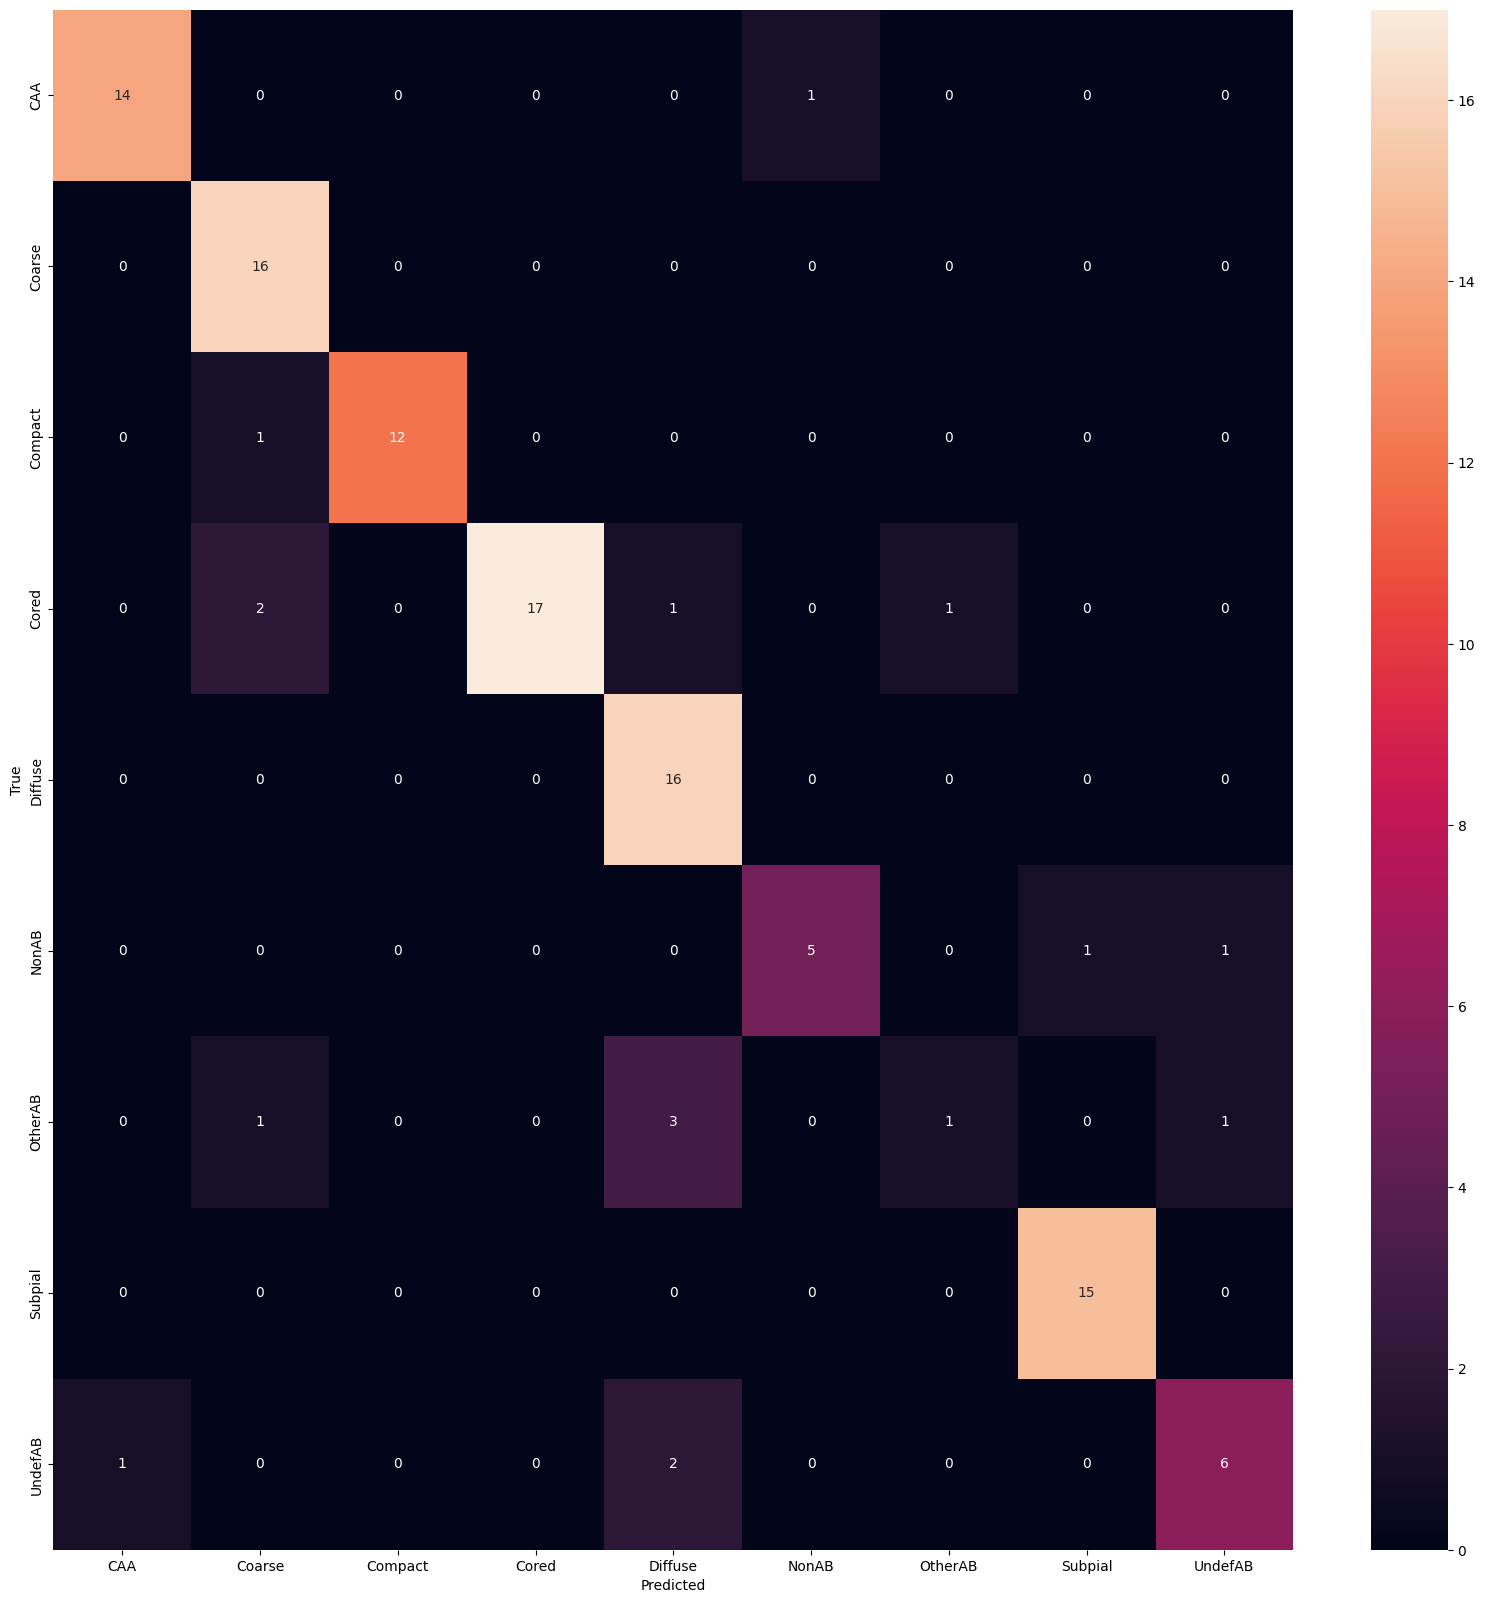

,Class,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Overall,86.44,83.13,80.15,80.13,97.14
1,CAA,93.33,93.33,93.33,93.33,99.94
2,Coarse,100.00,80.00,100.00,88.89,99.33
3,Compact,92.31,100.00,92.31,96.00,100.00
4,Cored,80.95,100.00,80.95,89.47,98.33
5,Diffuse,100.00,72.73,100.00,84.21,98.96
6,NonAB,71.43,83.33,71.43,76.92,99.74
7,OtherAB,16.67,50.00,16.67,25.00,86.90
8,Subpial,100.00,93.75,100.00,96.77,99.94
9,UndefAB,66.67,75.00,66.67,70.59,91.13


In [ ]:
# Load pretrained ResNet (e.g., ResNet18)
res18_model = models.resnet18(pretrained=True)

res18_model.fc = nn.Linear(res18_model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res18_model.parameters(), lr=LEARNING_RATE)
train(res18_model, train_loader, criterion, optimizer, val_loader = validation_loader, device = device, num_epochs=NUM_EPOCHS, early_stopping = True)
test_acc, test_loss, test_predictions, test_predictions_probabilities = evaluate(res18_model, test_loader, criterion, device)
print(f"Test data average loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
draw_confusion_matrix(test_image_labels, test_predictions)
generate_metrics_table(np.array(test_predictions), np.array(test_image_labels), test_predictions_probabilities)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]
Epoch [1/50]: 100%|██████████| 12/12 [00:03<00:00,  3.22it/s, acc=12.8, loss=2.11]


Epoch 1/50 - Train Loss: 2.1827 - Train Acc: 12.77% - Val Loss: 2.2473 - Val Acc: 0.09%


Epoch [2/50]: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s, acc=45.5, loss=1.78]


Epoch 2/50 - Train Loss: 1.8590 - Train Acc: 45.48% - Val Loss: 1.9050 - Val Acc: 0.49%


Epoch [3/50]: 100%|██████████| 12/12 [00:03<00:00,  3.24it/s, acc=70.7, loss=1.43]


Epoch 3/50 - Train Loss: 1.6159 - Train Acc: 70.74% - Val Loss: 1.6578 - Val Acc: 0.57%


Epoch [4/50]: 100%|██████████| 12/12 [00:03<00:00,  3.26it/s, acc=86.7, loss=1.4]


Epoch 4/50 - Train Loss: 1.3586 - Train Acc: 86.70% - Val Loss: 1.4688 - Val Acc: 0.69%


Epoch [5/50]: 100%|██████████| 12/12 [00:03<00:00,  3.25it/s, acc=91.8, loss=1.17]


Epoch 5/50 - Train Loss: 1.1453 - Train Acc: 91.76% - Val Loss: 1.2995 - Val Acc: 0.73%


Epoch [6/50]: 100%|██████████| 12/12 [00:03<00:00,  3.19it/s, acc=92.8, loss=0.903]


Epoch 6/50 - Train Loss: 0.9611 - Train Acc: 92.82% - Val Loss: 1.1539 - Val Acc: 0.77%


Epoch [7/50]: 100%|██████████| 12/12 [00:03<00:00,  3.23it/s, acc=93.1, loss=0.753]


Epoch 7/50 - Train Loss: 0.7822 - Train Acc: 93.09% - Val Loss: 1.0192 - Val Acc: 0.77%


Epoch [8/50]: 100%|██████████| 12/12 [00:03<00:00,  3.20it/s, acc=92.6, loss=0.688]


Epoch 8/50 - Train Loss: 0.6457 - Train Acc: 92.55% - Val Loss: 0.9127 - Val Acc: 0.77%


Epoch [9/50]: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s, acc=94.7, loss=0.456]


Epoch 9/50 - Train Loss: 0.5290 - Train Acc: 94.68% - Val Loss: 0.8414 - Val Acc: 0.79%


Epoch [10/50]: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s, acc=95.2, loss=0.493]


Epoch 10/50 - Train Loss: 0.4474 - Train Acc: 95.21% - Val Loss: 0.7773 - Val Acc: 0.77%


Epoch [11/50]: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s, acc=95.5, loss=0.38]


Epoch 11/50 - Train Loss: 0.3946 - Train Acc: 95.48% - Val Loss: 0.7240 - Val Acc: 0.80%


Epoch [12/50]: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s, acc=96.5, loss=0.334]


Epoch 12/50 - Train Loss: 0.3295 - Train Acc: 96.54% - Val Loss: 0.6926 - Val Acc: 0.79%


Epoch [13/50]: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s, acc=97.1, loss=0.351]


Epoch 13/50 - Train Loss: 0.2860 - Train Acc: 97.07% - Val Loss: 0.6579 - Val Acc: 0.81%


Epoch [14/50]: 100%|██████████| 12/12 [00:04<00:00,  2.99it/s, acc=98.4, loss=0.277]


Epoch 14/50 - Train Loss: 0.2287 - Train Acc: 98.40% - Val Loss: 0.6332 - Val Acc: 0.82%


Epoch [15/50]: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s, acc=99.5, loss=0.192]


Epoch 15/50 - Train Loss: 0.2000 - Train Acc: 99.47% - Val Loss: 0.6089 - Val Acc: 0.83%


Epoch [16/50]: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s, acc=99.2, loss=0.14]


Epoch 16/50 - Train Loss: 0.1865 - Train Acc: 99.20% - Val Loss: 0.5843 - Val Acc: 0.81%


Epoch [17/50]: 100%|██████████| 12/12 [00:03<00:00,  3.04it/s, acc=99.2, loss=0.12]


Epoch 17/50 - Train Loss: 0.1727 - Train Acc: 99.20% - Val Loss: 0.5688 - Val Acc: 0.82%


Epoch [18/50]: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s, acc=99.5, loss=0.111]


Epoch 18/50 - Train Loss: 0.1437 - Train Acc: 99.47% - Val Loss: 0.5573 - Val Acc: 0.84%


Epoch [19/50]: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s, acc=99.7, loss=0.363]


Epoch 19/50 - Train Loss: 0.1265 - Train Acc: 99.73% - Val Loss: 0.5369 - Val Acc: 0.83%


Epoch [20/50]: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s, acc=100, loss=0.122]


Epoch 20/50 - Train Loss: 0.1003 - Train Acc: 100.00% - Val Loss: 0.5324 - Val Acc: 0.84%


Epoch [21/50]: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s, acc=100, loss=0.0628]


Epoch 21/50 - Train Loss: 0.0837 - Train Acc: 100.00% - Val Loss: 0.5258 - Val Acc: 0.83%


Epoch [22/50]: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s, acc=100, loss=0.0436]


Epoch 22/50 - Train Loss: 0.0851 - Train Acc: 100.00% - Val Loss: 0.5110 - Val Acc: 0.83%


Epoch [23/50]: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s, acc=100, loss=0.0611]


Epoch 23/50 - Train Loss: 0.0793 - Train Acc: 100.00% - Val Loss: 0.5029 - Val Acc: 0.85%


Epoch [24/50]: 100%|██████████| 12/12 [00:03<00:00,  3.14it/s, acc=100, loss=0.0875]


Epoch 24/50 - Train Loss: 0.0632 - Train Acc: 100.00% - Val Loss: 0.4972 - Val Acc: 0.85%


Epoch [25/50]: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s, acc=100, loss=0.0372]


Epoch 25/50 - Train Loss: 0.0494 - Train Acc: 100.00% - Val Loss: 0.4903 - Val Acc: 0.83%


Epoch [26/50]: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s, acc=100, loss=0.07]


Epoch 26/50 - Train Loss: 0.0504 - Train Acc: 100.00% - Val Loss: 0.4936 - Val Acc: 0.83%


Epoch [27/50]: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s, acc=100, loss=0.0521]


Epoch 27/50 - Train Loss: 0.0522 - Train Acc: 100.00% - Val Loss: 0.4923 - Val Acc: 0.82%


Epoch [28/50]: 100%|██████████| 12/12 [00:03<00:00,  3.13it/s, acc=100, loss=0.0425]


Epoch 28/50 - Train Loss: 0.0412 - Train Acc: 100.00% - Val Loss: 0.4733 - Val Acc: 0.83%


Epoch [29/50]: 100%|██████████| 12/12 [00:03<00:00,  3.14it/s, acc=100, loss=0.056]


Epoch 29/50 - Train Loss: 0.0448 - Train Acc: 100.00% - Val Loss: 0.4719 - Val Acc: 0.82%


Epoch [30/50]: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s, acc=99.7, loss=0.0392]


Epoch 30/50 - Train Loss: 0.0481 - Train Acc: 99.73% - Val Loss: 0.4799 - Val Acc: 0.83%


Epoch [31/50]: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s, acc=100, loss=0.0391]


Epoch 31/50 - Train Loss: 0.0399 - Train Acc: 100.00% - Val Loss: 0.4710 - Val Acc: 0.87%


Epoch [32/50]: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s, acc=100, loss=0.0286]


Epoch 32/50 - Train Loss: 0.0303 - Train Acc: 100.00% - Val Loss: 0.4705 - Val Acc: 0.87%


Epoch [33/50]: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s, acc=100, loss=0.0431]


Epoch 33/50 - Train Loss: 0.0315 - Train Acc: 100.00% - Val Loss: 0.4660 - Val Acc: 0.87%


Epoch [34/50]: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s, acc=100, loss=0.0334]


Epoch 34/50 - Train Loss: 0.0333 - Train Acc: 100.00% - Val Loss: 0.4723 - Val Acc: 0.87%


Epoch [35/50]: 100%|██████████| 12/12 [00:03<00:00,  3.09it/s, acc=100, loss=0.0562]


Epoch 35/50 - Train Loss: 0.0293 - Train Acc: 100.00% - Val Loss: 0.4835 - Val Acc: 0.85%


Epoch [36/50]: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s, acc=100, loss=0.0845]


Epoch 36/50 - Train Loss: 0.0329 - Train Acc: 100.00% - Val Loss: 0.4665 - Val Acc: 0.86%
Early stopping triggered after 36 epochs!
Test data average loss: 0.4505, accuracy: 0.8729


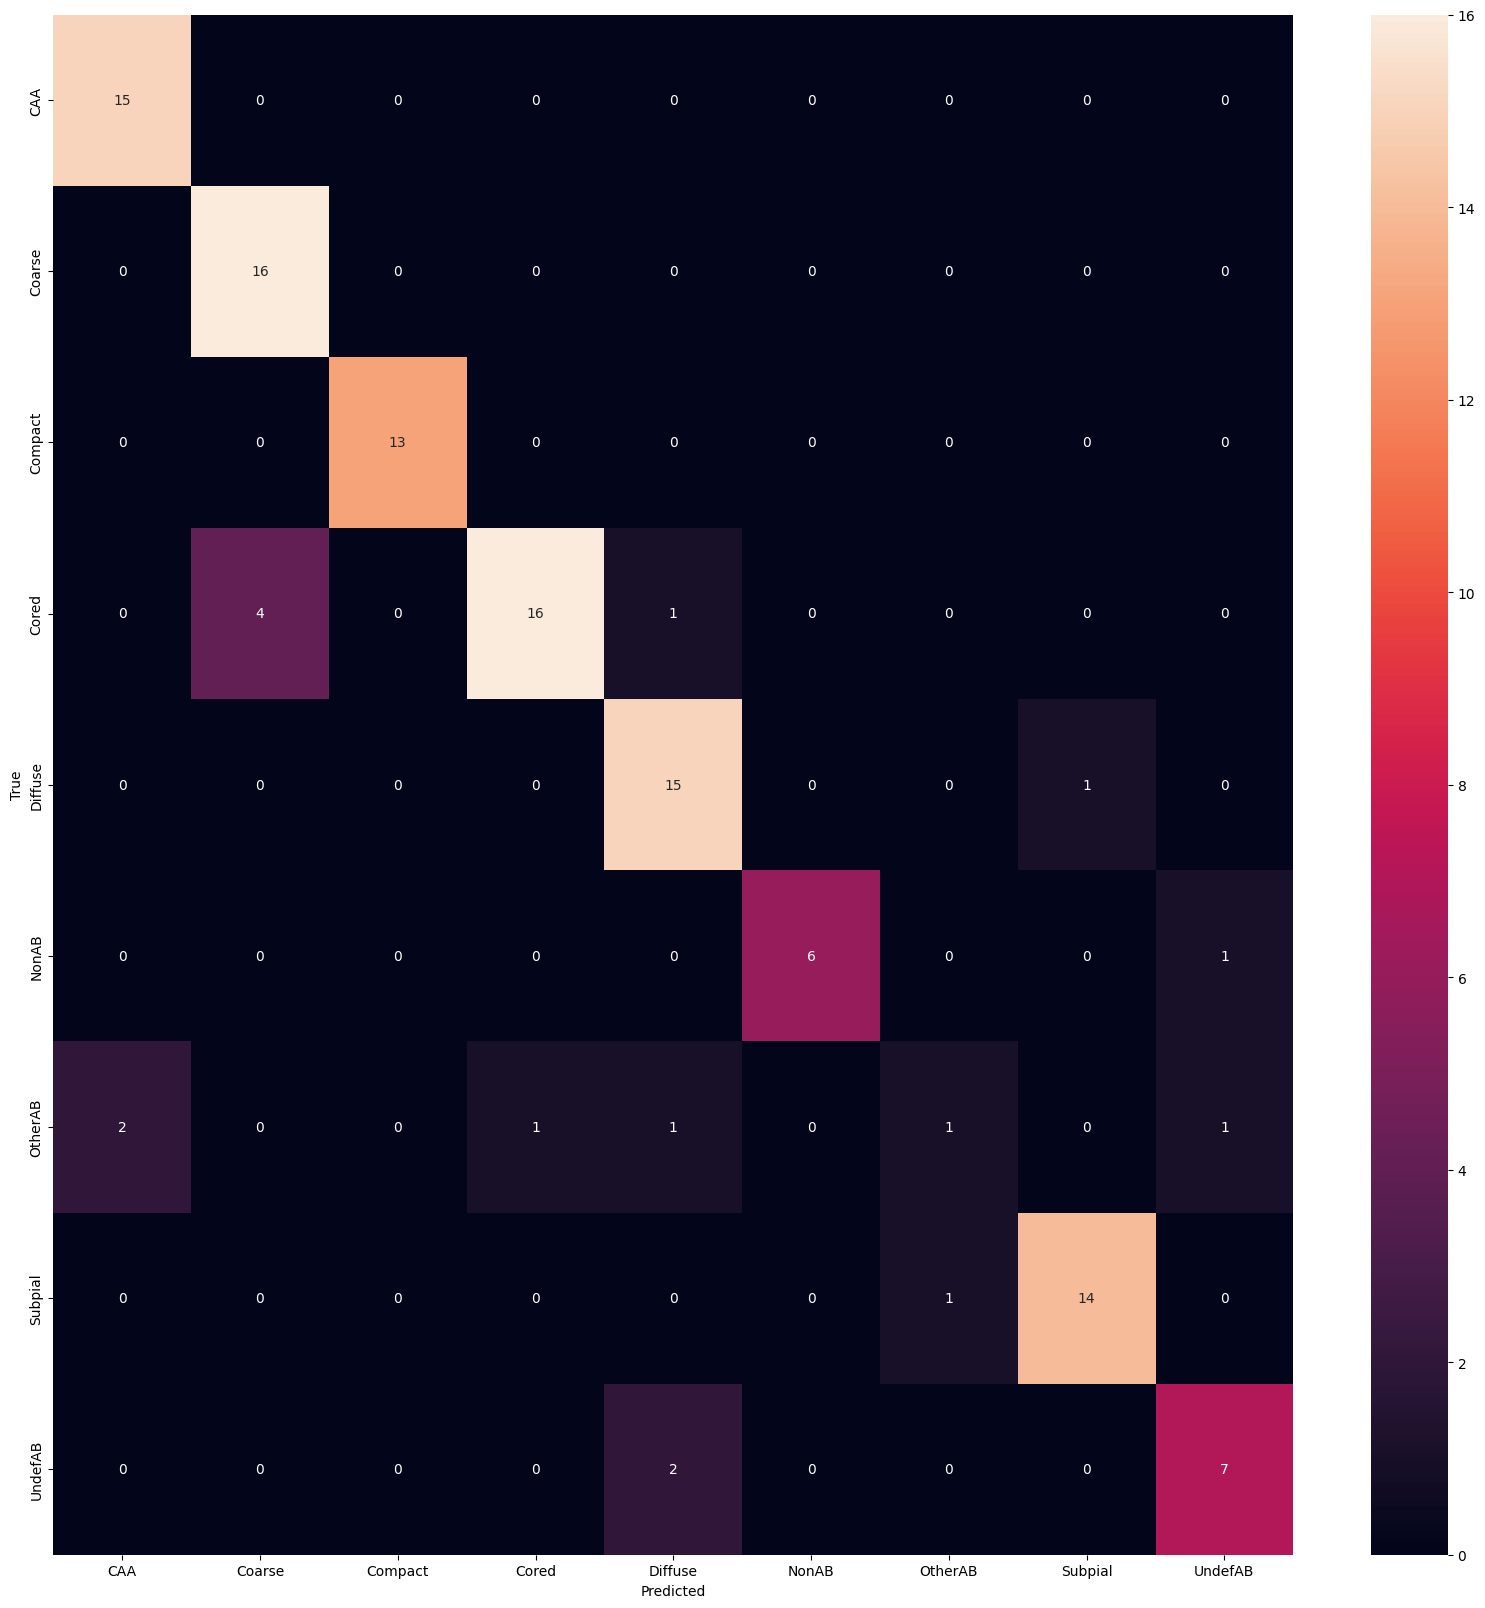

,Class,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Overall,87.29,84.71,82.60,82.33,97.26
1,CAA,100.00,88.24,100.00,93.75,100.00
2,Coarse,100.00,80.00,100.00,88.89,98.53
3,Compact,100.00,100.00,100.00,100.00,100.00
4,Cored,76.19,94.12,76.19,84.21,96.61
5,Diffuse,93.75,78.95,93.75,85.71,99.02
6,NonAB,85.71,100.00,85.71,92.31,98.84
7,OtherAB,16.67,50.00,16.67,25.00,90.77
8,Subpial,93.33,93.33,93.33,93.33,99.81
9,UndefAB,77.78,77.78,77.78,77.78,91.74


In [ ]:
# Load pretrained ResNet (e.g., ResNet50)
res50_model = models.resnet50(pretrained=True)

res50_model.fc = nn.Linear(res50_model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res50_model.parameters(), lr=LEARNING_RATE)
train(res50_model, train_loader, criterion, optimizer, val_loader = validation_loader, device = device, num_epochs=NUM_EPOCHS, early_stopping = True)
test_acc, test_loss, test_predictions, test_predictions_probabilities = evaluate(res50_model, test_loader, criterion, device)
print(f"Test data average loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
draw_confusion_matrix(test_image_labels, test_predictions)
generate_metrics_table(np.array(test_predictions), np.array(test_image_labels), test_predictions_probabilities)